# 4. Modelowanie

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# statystyki, metryki
from statistics import mean, stdev
from sklearn.metrics import roc_auc_score
from sklearn import metrics

## Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# podział zbioru
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold

# standaryzacja
from sklearn.preprocessing import StandardScaler

# modele
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier()


# optymalizacja
from sklearn.model_selection import GridSearchCV
# from sklearn.model_selection import RandomizedSearchCV

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

# from sklearn.exceptions import DataConversionWarning
# warnings.filterwarnings(action='ignore', category=DataConversionWarning)

In [3]:
# importuję plik z funkcjami w pythonie
import modelling

In [4]:
df = pd.read_csv("Loan_data_new_variables.csv")
df_x = df.drop('target', axis=1)
df_y = df[['target']]

## Klasteryzacja (analiza skupień)

- metoda k-średnich - K-means
- hierarchiczna analiza skupień (HCA),
- DBSCAN (tez może służyć do wyodrębniania obserwacji odstających)
- algorytm oczekiwanie-maksymalizacja,

### K-means

Określam optymalną liczbę klastrów

In [ ]:
#  metoda 1: metoda łokcia (elbow curve)
ssd = [] # suma kwadratów odległości
range_n_clusters = [*range(2,11)]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(df_x)
    ssd.append(kmeans.inertia_)
    
plt.plot(ssd)
plt.show()

Z powyższego wykresu wynika, że optymalną liczbą klastrów jest 3, 5 lub 8 (po uwzględnieniu przesunięcia w skali, która jest od 0 do 8)

In [ ]:
# metoda 2: Miara wewnętrzna - wskaźnik sylwetkowy
range_n_clusters = [*range(2,11)]

for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=1000)
    kmeans.fit(df_x)
    cluster_labels = kmeans.labels_
    
    silhouette_avg = silhouette_score(df_x, cluster_labels)
    print(f"For {num_clusters}, the silhouette score is {silhouette_avg}")

Według wskaźnika sylwetkowego optymalna liczba klastrów to 2, 3 lub 5.
Wybieram więc 3 klastry.

In [ ]:
# liczba klastrów n = 3
kmeans = KMeans(n_clusters=3, max_iter=1000)
kmeans.fit(df_x)

In [ ]:
# dodaję zmienną z wynikiem podziału na klastry do zbioru
df_x['kmeans_cluster_3'] = pd.DataFrame(kmeans.labels_).copy()

In [ ]:
for column in df_x.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='kmeans_cluster_3', y=column, data=df_x)

Zmienne, które rozróżniają te obserwacje to są: wysokość kwoty pożyczki, oprocentowanie, rata, długość zatrudnienia, dochód, fico score,
dochód kategoryzowany, wysokość kwoty pożyczki kategoryzowana, 

Mniej wyraźnie: term, revol_bal, total_acc, inc_ver_status, inc_ver_source_status,
earliest_cr_line_year, grade_num, home_Mortgage

a także zmienne binarne stworzone z powyższych zmiennych.

In [ ]:
plt.figure(figsize=(20,20))

plt.subplot(2,2,1)
sns.scatterplot(x='annual_inc_log+1',y='int_rate_log+1',data=df_x,hue='kmeans_cluster_3')

plt.subplot(2,2,2)
sns.scatterplot(x='annual_inc_log+1',y='loan_amnt_log+1',data=df_x,hue='kmeans_cluster_3')

plt.subplot(2,2,3)
sns.scatterplot(x='annual_inc_log+1',y='installment_log+1',data=df_x,hue='kmeans_cluster_3')

plt.subplot(2,2,4)
sns.scatterplot(x='annual_inc_log+1',y='fico_range_low',data=df_x,hue='kmeans_cluster_3')

plt.show()

In [ ]:
plt.figure(figsize=(20,20)) #,dpi=200

plt.subplot(2,2,1)
sns.scatterplot(x='loan_amnt_log+1',y='int_rate_log+1',data=df_x,hue='kmeans_cluster_3')

plt.subplot(2,2,2)
sns.scatterplot(x='loan_amnt_log+1',y = 'emp_length',data=df_x,hue='kmeans_cluster_3')

plt.subplot(2,2,3)
sns.scatterplot(x='loan_amnt_log+1',y='issue_d_month',data=df_x,hue='kmeans_cluster_3')

plt.subplot(2,2,4)
sns.scatterplot(x='loan_amnt_log+1',y='fico_range_low',data=df_x,hue='kmeans_cluster_3')

plt.show()

Podsumowanie - komentarz:

- 0: wysoki dochód, wysokie oprocentowanie, wysoka kwota kredytu, niski/średni fico score, długie zatrudnienie -> średnie/większe ryzyko
- 1: niski dochód, średnie oprocentowanie, niska kwota kredytu, niski fico score, krótkie zatrudnienie -> większe ryzyko
- 2: średni dochód, niskie oprocentowanie, średnia kwita kredytu, wysoki fico score, długie zatrudnienie -> niższe ryzyko

Sprawdźmy te przypuszczenia:

In [ ]:
df_all = pd.concat([df_x, df_y], axis=1)

In [ ]:
df_all.groupby('kmeans_cluster_3')['target'].mean()

Przypuszczenia się sprawdziły. Najniższy odsetek niespłacających jest w klastrze 2, najwyższy w klastrze 0, i odrobinę wyższy w klastrze 1. Czyli pod względem prawdopodobieństwa niespłacenia długu odrożnia się klaster 2, w którym jest ono najmniejsze. 

### Hierarchical clustering

Druga metoda klastrowania. Tą metodę było mi trudno przeprowadzic na całym zbiorze, ze względu na moc obliczeniową. Dlatego zdecydowałam wykonać ją na zbiorze ograniczonym - wyodrębniłam część zmiennych najbardzirj różnicujących zbiór według metody K-means.

In [ ]:
hc_vars = ['int_rate_log+1', 'installment_log+1', 'emp_length', 'fico_range_low', 'revol_bal', 'annual_inc_log+1',
           'loan_amnt_log+1', 'grade_num', 'term', 'emp_length_bin', 'int_rate_bin', 'annual_inc_bin', 'installmentc_bin',
          'loan_amnt_bin']

In [ ]:
df_hc = df_x[hc_vars]

In [ ]:
sl_mergings = linkage(df_hc)
dendrogram(sl_mergings)
plt.show()

Niestety również i ten sposób nie pomógł (komunikat "The kernel appears to have died. It will restart automatically" ale niestety to się nie dzieje), więc zostawiam ten algorytm.

### DBSCAN

In [ ]:
dbscan_classifier = DBSCAN()
dbscan_classifier.fit(df_x)

In [ ]:
n_clusters = len(set(dbscan_classifier.labels_)) - (1 if -1 in dbscan_classifier.labels_ else 0)
n_noise = list(dbscan_classifier.labels_).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

Algorytm nie znajduje żadnego klastra. Wobec tego szukam optymalnych parametrów.

In [ ]:
from sklearn.neighbors import NearestNeighbors

neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(df_x)
distances, indices = nbrs.kneighbors(df_x)

In [ ]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(distances)
plt.axhline(y = 4.5, color = 'r', linestyle = '-')
plt.show()

Na tym wykresie szukam przegięcia - tam znajduje się optymalna odległość epsilon - w tym wypadku wynosi ona ok 5.

In [ ]:
dbscan_classifier = DBSCAN(eps=5)
dbscan_model = dbscan_classifier.fit(df_x)

In [ ]:
n_clusters = len(set(dbscan_classifier.labels_)) - (1 if -1 in dbscan_classifier.labels_ else 0)
n_noise = list(dbscan_classifier.labels_).count(-1)

print(f'Estimated number of clusters: {n_clusters}')
print(f'Estimated number of noise points: {n_noise}')

To jest dość sporo klastrów, ale jednocześnie wiem, że zbiór jest spory i może być różnorodny. Zobaczmy, w jaki sposób DBSCAN go podzielił.

In [ ]:
df_x['dbscan_cluster'] = pd.DataFrame(dbscan_classifier.labels_).copy()

Teraz chcę zwizualizować podział na klastry dokonany przez DBSCAN. W tym celu wykonuję redukcję wymiarów t-SNE, dopisuję dwa wymiary do źródłowego dataframe'a, i wyświetlam wyniki na wykresie punktowym.

In [ ]:
from sklearn.manifold import TSNE

x_tsne_array = TSNE(n_components=2).fit_transform(df_x)

In [ ]:
df_x["tsne_x_component"] = x_tsne_array[:,0]
df_x["tsne_y_component"] = x_tsne_array[:,1]

In [ ]:
plt.figure(figsize=(20,15))
sns.scatterplot(x='tsne_x_component',y='tsne_y_component',data=df_x,hue='dbscan_cluster')
plt.show()

In [ ]:
df_x['dbscan_cluster'].value_counts()

Najwidoczniej grupa klientów nie dzieli się na wyraźne podgrupy, zdecydowana większość znajduje się w jednym klastrze, jest także sporo klastrów z pojedynczymi obserwacjami.

In [ ]:
# ponieważ cały dataset jest wystandaryzowany, a nowo dodane zmienne z klasteryzacji nie, to standaryzuję je też
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_new_vars = df_x[['kmeans_cluster_3', 'tsne_x_component', 'tsne_y_component']].copy()
scaled_x_array = scaler.fit_transform(df_new_vars)
df_new_vars = pd.DataFrame(scaled_x_array,columns=df_new_vars.columns) 

df_x[['kmeans_cluster_3', 'tsne_x_component', 'tsne_y_component']] = df_new_vars

In [ ]:
df_x.to_csv('Loan_data_x_after_unsupervised.csv', index=False)

In [ ]:
# df_x = pd.read_csv('Loan_data_x_after_unsupervised_v2.csv')
# df_y = pd.read_csv("Loan_data_y_v2.csv")

## Uczenie nadzorowane

In [ ]:
df_x[sorted(df_x)].columns.tolist()

In [ ]:
# pierwszy zestaw predyktorów - zmienne wyjściowe
predictors_orig = [
'acc_ratio',
 'annual_inc',
 'annual_inc_bin',
 'annual_inc_outliers',
 'dbscan_cluster',
 'delinq_2yrs',
 'delinq_2yrs_outliers',
 'dti',
 'earliest_cr_line_month',
 'earliest_cr_line_year',
 'emp_length',
 'emp_length_bin',
 'fico_range_low',
 'grade_num',
 'home_MORTGAGE',
 'home_OTHER',
 'home_OWN',
 'home_RENT',
 'inc_source_ver_status',
 'inc_ver_status',
 'inq_last_6mths',
 'installment',
 'installment_outliers',
 'installmentc_bin',
 'int_rate',
 'int_rate_bin',
 'issue_d_month',
 'issue_d_year',
 'kmeans_cluster_3',
 'loan_amnt', 
 'loan_amnt_bin',
 'open_acc',
 'revol_bal',
 'revol_bal_outliers',
 'revol_util',
 'term',
 'total_acc',
 'tsne_x_component',
 'tsne_y_component'
]

In [5]:
# drugi zestaw predyktorów - logarytmowane
predictors_log = [
'acc_ratio',
 'annual_inc_bin', 
'annual_inc_log+1',
 'annual_inc_outliers',
 # 'dbscan_cluster',  # usuwam, bo nie zrobiłam tymczasowo nienadzorowanego
 'delinq_2yrs',
 'delinq_2yrs_outliers',
 'dti',
 'earliest_cr_line_month',
 'earliest_cr_line_year',
 'emp_length',
 'emp_length_bin',
 'fico_range_low',
 'grade_num',
 'home_MORTGAGE',
 'home_OTHER',
 'home_OWN',
 'home_RENT',
 'inc_source_ver_status',
 'inc_ver_status',
 'inq_last_6mths',
 'installment_log+1',
 'installment_outliers',
 'installmentc_bin',
 'int_rate', 'int_rate_log+1',
 'int_rate_bin',
 'issue_d_month',
 'issue_d_year',
 # 'kmeans_cluster_3', # usuwam, bo nie zrobiłam tymczasowo nienadzorowanego
 'loan_amnt_log+1',
 'loan_amnt_bin',
 'open_acc',
 'revol_bal',
 'revol_bal_outliers',
 'revol_util',
 'term',
 'total_acc',
 # 'tsne_x_component', # usuwam, bo nie zrobiłam tymczasowo nienadzorowanego
 # 'tsne_y_component' # usuwam, bo nie zrobiłam tymczasowo nienadzorowanego
]

In [ ]:
# trzeci zestaw - zmienne kategoryzowane
predictors_cat = [
 'acc_ratio',
 'annual_inc_bin',
 'annual_inc_cat_10',
 'annual_inc_outliers',
 'dbscan_cluster',
 'delinq_2yrs',
 'delinq_2yrs_outliers',
 'dti',
 'earliest_cr_line_month',
 'earliest_cr_line_year',
 'emp_length',
 'emp_length_bin',
 'fico_range_low_cat_num',
 'grade_num',
 'home_MORTGAGE',
 'home_OTHER',
 'home_OWN',
 'home_RENT',
 'inc_source_ver_status',
 'inc_ver_status',
 'inq_last_6mths',
 'installment',
 'installment_outliers',
 'installmentc_bin',
 'int_rate',
 'int_rate_bin',
 'issue_d_month',
 'issue_d_year',
 'kmeans_cluster_3',
 'loan_amnt_cat_10',
 'loan_amnt_bin',
 'open_acc',
 'revol_bal',
 'revol_bal_outliers',
 'revol_util',
 'term',
 'total_acc',
 'tsne_x_component',
 'tsne_y_component'
]

In [6]:
df_x = df_x[predictors_log]

### SMOTE - Balancing for imbalanced clasification

In [7]:
# SMOTE balancing
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

sm = SMOTE(random_state=42)
df_x, df_y = sm.fit_resample(df_x, df_y)
# jak robię balansowanie klas, to tylko na zbiorze treningowym

# wyświetlam efekt
from collections import Counter
print('Resampled dataset shape %s' % Counter(df_y['target']))

# # (albo po prostu tak jak robiłam to wcześniej:)
# # rozkład zmiennej - procentowo
# val = df_y['target'].value_counts()#.sort_values()
# round(100*(val/len(df_y.index)), 2)

Resampled dataset shape Counter({1: 34116, 0: 34116})


### 1. Regresja Logistyczna

In [8]:
logReg = modelling.Model(df_x, df_y, LogisticRegression(max_iter=500))
logReg.train_model()

List of AUROC scores: [0.8843875110120958, 0.8888569444578065, 0.8820311192359868, 0.8887901634014221, 0.8895887314436468, 0.8874410009956754, 0.8928795810258721, 0.8914449252693598, 0.8914742250006272, 0.8827972943201826]

Mean AUROC: 88.797 %


In [9]:
modelling.compare_results('Logistic Regression', logReg.auroc_mean)

,Method,ROC AUC score
1,Logistic Regression,0.888


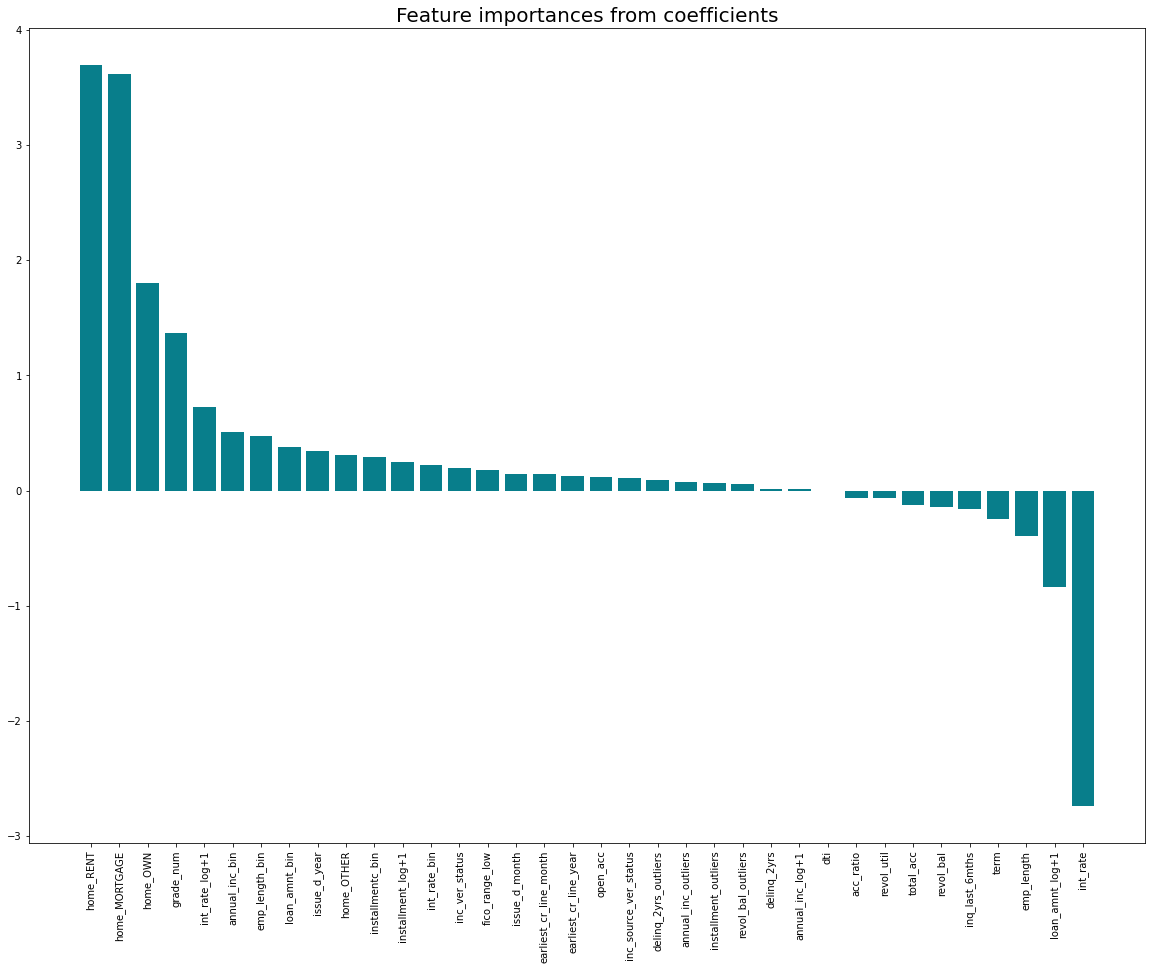

In [10]:
importances = pd.DataFrame(data={
    'Attribute': df_x.columns,
    'Importance': logReg.model.coef_[0]
})
importances = importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(20,15))
plt.bar(x=importances['Attribute'], height=importances['Importance'], color='#087E8B')
plt.title('Feature importances from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

Zmienne o zerowym/znikomym znaczeniu: open_acc, total_acc, inc_ver_status, dti

In [ ]:
# nic nie wywalam na razie, a może i w ogóle.
# df_x = df_x.drop(columns=['dti', 'delinq_2yrs']) # annual_inc_log+1 ??? ta zmienna powinna mieć bardzo duże znaczenie.                                                   

### 2. Random Forest

In [11]:
randFor = modelling.Model(df_x, df_y, RandomForestClassifier())
randFor.train_model()

List of AUROC scores: [0.9375292481951157, 0.9374715678338228, 0.9074288738283115, 0.9147001477531316, 0.950356159284681, 0.9355880206888754, 0.9320973142886799, 0.9534460780118663, 0.9195260970386477, 0.9109151981572616]

Mean AUROC: 92.991 %


In [12]:
modelling.compare_results('Random Forest', randFor.auroc_mean)

,Method,ROC AUC score
1,Logistic Regression,0.888
2,Random Forest,0.930


### 3. K-NN

Najpierw wybieram optymalne K - sprawdzam średni błąd dla K w zakresie od 1 do 30.

In [19]:
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, test_size=0.3, random_state=0, stratify = df_y)

In [21]:
# modelling.standarize_dataset(train_x)
# modelling.standarize_dataset(test_x) # tego spróbowałam, ale zaniepokoił mnie wynik więc spróbowałam jeszcze raz na piechotę
# to zrobić poniżej - z tym samym efektem, więc prawdopodobnie równie dobrze mogłabym użyc funkcji z pliku
scaler = StandardScaler()

scaled_x_array = scaler.fit_transform(train_x)
train_x = pd.DataFrame(scaled_x_array,columns=train_x.columns)

scaled_x_array = scaler.fit_transform(test_x)
test_x = pd.DataFrame(scaled_x_array,columns=test_x.columns)

In [22]:
knn_error=[]
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(train_x,np.ravel(train_y))
    pred_i = knn.predict(test_x)
    knn_error.append(np.mean(pred_i != test_y.values)) 

# PONIŻEJ - CZEMU TEN ERROR SIĘ NIE ZMIENIA - zapytać na konsach

Text(0, 0.5, 'Mean error')

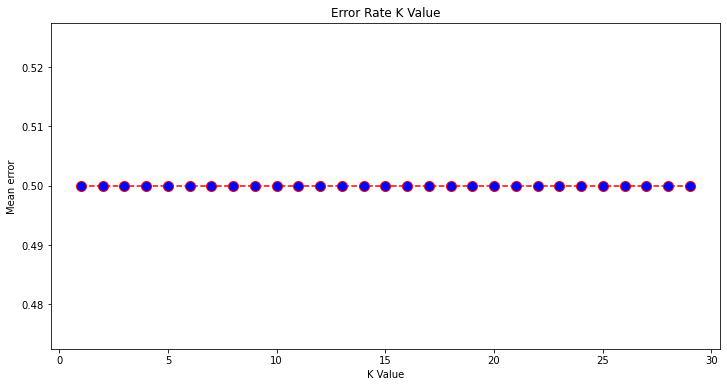

In [23]:
plt.figure(figsize=(12,6))
plt.plot(range(1,30), knn_error, color='red', linestyle='dashed', marker='o', markerfacecolor='blue', markersize=10)
plt.title('Error Rate K Value')
plt.xlabel('K Value')
plt.ylabel('Mean error')
# LOL czemu 

In [24]:
# dobra załóżmy, że wybieram k = 15
knn = modelling.Model(df_x, df_y, KNeighborsClassifier(n_neighbors=15))
knn.train_model()
modelling.compare_results('KNN Classifier', knn.auroc_mean)

List of AUROC scores: [0.9138736000379324, 0.9149494268212734, 0.9087991303221115, 0.9154690723722265, 0.9165490381267694, 0.9149587758795678, 0.9162751586739406, 0.9199148125349921, 0.9139640886683762, 0.9119486795874185]

Mean AUROC: 91.467 %


,Method,ROC AUC score
1,Logistic Regression,0.888
2,Random Forest,0.930
3,KNN Classifier,0.915


### 4. MLP

In [25]:
mlp = modelling.Model(df_x, df_y, MLPClassifier(max_iter=1000))
mlp.train_model()
modelling.compare_results('MLP Classifier', mlp.auroc_mean)

List of AUROC scores: [0.9199713548073211, 0.9236577440630888, 0.9152897511430332, 0.9268204412797298, 0.9293755325075792, 0.925736694914701, 0.9237052182391772, 0.9243850407429518, 0.9256107318471412, 0.9185926299404417]

Mean AUROC: 92.331 %


,Method,ROC AUC score
1,Logistic Regression,0.888
2,Random Forest,0.930
3,KNN Classifier,0.915
4,MLP Classifier,0.923


### 5. XGBoost

In [29]:
# from xgboost import XGBClassifier
# from lightgbm import LGBMClassifier

In [30]:
xgbm = modelling.Model(df_x, df_y, XGBClassifier())
xgbm.train_model()
modelling.compare_results('XGBoost', xgbm.auroc_mean)

List of AUROC scores: [0.8832203748854123, 0.8984765083307105, 0.8709743801775032, 0.8826361028367294, 0.8950748268738167, 0.8940812136996951, 0.8743087927032843, 0.9042907523174284, 0.8728444076006767, 0.8831747539080343]

Mean AUROC: 88.591 %


,Method,ROC AUC score
1,Logistic Regression,0.888
2,Random Forest,0.930
3,KNN Classifier,0.915
4,MLP Classifier,0.923
5,MLP Classifier,0.922
6,XGBoost,0.886


# wynik xgboost zaskakująco stosunkowo niski, może zapytac na konsach

### 6. Light GBM Boost

In [ ]:
# tego jeszcze nie uruchomiłam
lgbm = modelling.Model(df_x, df_y, LGBMClassifier())
lgbm.train_model()
modelling.compare_results('Light GBM', lgbm.auroc_mean)

# Modele na zbiorze PCA

# dorobiłam funkcję do PCA w pliku modelling, treba ją przetestować i przepuścić - tutaj skończyłam noc 31.05-01.06

### Regresja Logistyczna - PCA

In [ ]:
LogisticRegr_7 = LogisticRegression(max_iter=500)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    LogisticRegr_7.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LogisticRegr_7.predict_proba(x_test_fold)[:, 1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_7 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_7)*100, 3), '%')

### Random forest - PCA

In [ ]:
RandomForClass_8 = RandomForestClassifier()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    RandomForClass_8.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, RandomForClass_8.predict_proba(x_test_fold)[:, 1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_8 = np.mean(list_auroc_stratified) 
print('\nMean AUROC:', round((auroc_mean_8)*100, 3), '%')

In [ ]:
tempResultsDf = pd.DataFrame({'Method':['Random Forest PCA'], 'ROC AUC score': round(auroc_mean_8,3)},index=['8'])
results = pd.concat([results, tempResultsDf])
results

### KNN - PCA TUTAJ ZAKOŃCZYŁAM

In [ ]:
KNN_9 = KNeighborsClassifier(n_neighbors=15)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    KNN_9.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, KNN_9.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_9 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_9)*100, 3), '%')

In [ ]:
tempResultsDf = pd.DataFrame({'Method':['KNN PCA'], 'ROC AUC score': round(auroc_mean_9,3)},index=['9'])
results = pd.concat([results, tempResultsDf])
results

### MLP - PCA

In [ ]:
MLPmodel_10 = MLPClassifier(max_iter=1000)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    MLPmodel_10.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, MLPmodel_10.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_10 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_10)*100, 3), '%')

In [ ]:
tempResultsDf = pd.DataFrame({'Method':['MLP PCA'], 'ROC AUC score': round(auroc_mean_10,3)},index=['10'])
results = pd.concat([results, tempResultsDf])
results

### XGBoost - PCA

In [ ]:
XGBmodel_11 = xgb.XGBClassifier(random_state=1)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    XGBmodel_11.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, XGBmodel_11.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_11 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_11)*100, 3), '%')

In [ ]:
tempResultsDf = pd.DataFrame({'Method':['XGBClassifier PCA'], 'ROC AUC score': round(auroc_mean_11,3)},index=['11'])
results = pd.concat([results, tempResultsDf])
results

### Light GBM - PCA

In [ ]:
LGBMmodel_12 = lgb.LGBMClassifier()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    LGBMmodel_12.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LGBMmodel_12.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_12 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_12)*100, 3), '%')

In [ ]:
tempResultsDf = pd.DataFrame({'Method':['LGBMClassifier PCA'], 'ROC AUC score': round(auroc_mean_12,3)},index=['12'])
results = pd.concat([results, tempResultsDf])
results

Podsumowując działanie modeli na danych po PCA - w żadnym modelu poprawa metryki AUC ROC nie była wyraźna.

Modele, które odniosły lepszy rezultat przy PCA: MLP

Modele, które uzyskały niższy wynik: XGBoost, Light GBM

Porównywalny: regresja logistyczna, random forest, KNN

Najlepszy wynik osiągnęłam przy regresji logistycznej oraz Light GBM.

##  Optymalizacja

In [ ]:
df_x = pd.read_csv('Loan_data_x_after_unsupervised.csv')
df_x = df_x[predictors_log]

In [ ]:
# usuwam zmienne o znikomej istotności dla modelu
df_x = df_x.drop(columns=['open_acc', 'total_acc', 'inc_ver_status', 'dti'])

### Regresja logistyczna

In [ ]:
# sprawdzenie modelu na innym zastawie predyktorów
LogisticRegr_13 = LogisticRegression(max_iter=500)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    LogisticRegr_13.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LogisticRegr_13.predict_proba(x_test_fold)[:, 1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_13 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_13)*100, 3), '%')

In [ ]:
tempResultsDf = pd.DataFrame({'Method':['Reg Log - predictors log 2 '], 'ROC AUC score': round(auroc_mean_13,3)},index=['13'])
results = pd.concat([results, tempResultsDf])
results

Wynik na innym zestawie predyktorów oraz po usunięciu nieistotnych zmiennych nie zmienił się.

### GridSearch

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, random_state=0, stratify = df_y)

LogisticRegr_14 = LogisticRegression(max_iter=500, random_state=1)
grid = {
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    # 'penalty': ['l2'], # tego nie ustawiam, ponieważ jest to wartość domyślna. nie zmieniam 
    'C':  [100, 10, 1.0, 0.1, 0.01]
}

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=LogisticRegr_14, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(train_x, np.ravel(train_y))

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
params = grid_result.cv_results_['params']
for mean, param in zip(means, params):
    print(f"{mean} with:{param}")

Nie widać zauważalnej różnicy pomiędzy różnymi ustawieniami parametrów. 

Drugi w kolejności model pod względem AUC ROC score to był Light GBM - spróbuję więc jeszcze jego optymalizacji.

### Light GBM

In [ ]:
df_x = pd.read_csv('Loan_data_x_after_unsupervised.csv')
df_x = df_x[predictors_log]

In [ ]:
df_x = df_x.drop(columns=['open_acc', 'total_acc', 'inc_ver_status', 'dti'])

In [ ]:
# uruchamiam najpierw model na zmienionym zestawie predyktorów
import lightgbm as lgb
LGBMmodel_15 = lgb.LGBMClassifier(random_state = 0)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    LGBMmodel_15.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LGBMmodel_15.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_15 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_15)*100, 3), '%')

Wyniki na pozostałych zestawach predyktorów: 
- Na predyktorach oryginalnych predictors_orig - 68,54%
- logarytmicznych predictors_log - 68,439%
- kategoryzowanych predictors_cat -  68,601%
- logarytmicznych bez najmniej istotnych zmiennych - 68,758%

In [ ]:
tempResultsDf = pd.DataFrame({'Method':['Light GBM - predictors log '], 'ROC AUC score': round(auroc_mean_15,3)},index=['15'])
results = pd.concat([results, tempResultsDf])
results

In [ ]:
# trenuję model jeszcze raz w uproszczony sposób, aby wyświetlić feature importances
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, random_state=0, stratify = df_y['target'])
LGBMmodel_15.fit(train_x, np.ravel(train_y))

In [ ]:
lgb.plot_importance(LGBMmodel_15, figsize=(40,20))

Z wykresu feature importances wynika, że najmniejsze znaczenie dla modelu posiadają zmienne: revol_bal_outliers, loan_amnt_bin oraz delinq_2yrs_outliers. Usuwam je więc z zestawu predyktorów.

In [ ]:
df_x = df_x.drop(columns=['revol_bal_outliers', 'loan_amnt_bin', 'delinq_2yrs_outliers'])

In [ ]:
# powtarzam operację powyżej
for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]    
    LGBMmodel_15.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LGBMmodel_15.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_15 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_15)*100, 3), '%')

In [ ]:
tempResultsDf = pd.DataFrame({'Method':['Light GBM - less features '], 'ROC AUC score': round(auroc_mean_15,3)},index=['15'])
results = pd.concat([results, tempResultsDf])
results

Wynik pozostał taki sam.


### Light GBM Grid Search

Manipuluję parametrami, jednak ze względu na czas obliczeniowy dzielę to na dwie tury, pozostawiając częśc parametrów stałych.

dla parametrów:
  - 'num_leaves' default = 31
  - 'max_depth': [-1, 5, 10],
  - 'min_child_samples': [20, 40, 60, 80, 100],
  - 'max_bin' default = 255
  - 'boosting_type': ['dart', 'gbdt', 'goss'],
  - 'learning_rate' default = 0.1

Najlepszy wynik:

Best: 0.6892187140351865 using {'boosting_type': 'dart', 'max_depth': 5, 'min_child_samples': 100}

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, random_state=0, stratify = df_y)
LGBMmodel_16 = lgb.LGBMClassifier(random_state = 0)

grid = {
    'max_depth': [5],
    'min_child_samples': [100, 120, 140, 200],
    'boosting_type': ['dart'],
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=LGBMmodel_16, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(train_x, np.ravel(train_y))

print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))    

Ustawiam więc 'boosting_type': 'dart', 'max_depth': 5, 'min_child_samples': 100

Następna część hiperparametrów:

przy tych parametrach:
- 'num_leaves': [50, 70, 90, 110], # less then 2^max_depth, default 31, large may cause overfitting
- 'max_bin': [200, 350, 500], # default is 255, larger for better accuracy
- 'learning_rate': [0.01, 0.05, 0.1, 0.3] # small for better accuracy, default 0.1

Best: 0.68876 using {'learning_rate': 0.1, 'max_bin': 200, 'num_leaves': 50}

przy kolejnych:
- 'num_leaves': [20, 31, 50, 70], # less then 2^max_depth, default 31, large may cause overfitting
- 'max_bin': [150, 200, 350], # default is 255, larger for better accuracy
- 'learning_rate': [0.05, 0.1] # small for better accuracy, default 0.1

Best: 0.6895239010483522 using {'learning_rate': 0.1, 'max_bin': 350, 'num_leaves': 20}

przy kolejnych:
- 'num_leaves': [8, 9, 10, 15, 20, 31], # less then 2^max_depth, default 31, large may cause overfitting
- 'max_bin': [200, 350, 400, 450], # default is 255, larger for better accuracy
- 'learning_rate': [0.1] # small for better accuracy, default 0.1

Best: 0.6904702388372592 using {'learning_rate': 0.1, 'max_bin': 200, 'num_leaves': 10}

In [ ]:
LGBMmodel_17 = lgb.LGBMClassifier(random_state = 0, boosting_type='dart', max_depth = 5, min_child_samples = 100)

grid = {    
    'num_leaves': [8, 9, 10],
    'max_bin': [200],
    'learning_rate': [0.1]
}
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

grid_search = GridSearchCV(estimator=LGBMmodel_17, param_grid=grid, n_jobs=-1, cv=cv, scoring='roc_auc',error_score=0)
grid_result = grid_search.fit(train_x, np.ravel(train_y))
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Wybieram więc ostateczne hiperparametry i trenuję z nimi model raz jeszcze.

In [ ]:
LGBMmodel_18 = lgb.LGBMClassifier(
    random_state = 0,
     num_leaves = 10,
     max_depth = 5,
     min_child_samples = 100,
     max_bin = 200,
     boosting_type = 'dart',
     learning_rate = 0.1
)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
list_auroc_stratified = []

array_x = df_x.to_numpy()
array_y = df_y.to_numpy()

for train_index, test_index in skf.split(df_x, df_y):
    x_train_fold, x_test_fold = array_x[train_index], array_x[test_index]
    y_train_fold, y_test_fold = array_y[train_index], array_y[test_index]
    LGBMmodel_18.fit(x_train_fold, np.ravel(y_train_fold))
    list_auroc_stratified.append(roc_auc_score(y_test_fold, LGBMmodel_18.predict_proba(x_test_fold)[:,1]))

print('List of aurocs:', list_auroc_stratified)
auroc_mean_18 = np.mean(list_auroc_stratified)
print('\nMean AUROC:', round((auroc_mean_18)*100, 3), '%')

To jest mój ostateczny model z wynikiem 68,869% - jak widać optymalizacja hiperparametrów nie poprawiła wyniku wyraźnie. Jest to prawdopodobnie maksimum, które można otrzymac przy danym zbiorze.